In [65]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"



#| output: false
# 여기에 온갖코드를 넣음.
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)



tidydata1 = df_feature.pivot_table(
    index = 'dayofweek',
    columns = 'pickup_hour',
    values = 'speed',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'mean_speed'}, axis =1)



df_small = df[::100].reset_index(drop=True)

pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_small2 = df_left.merge(df_right)
tidydata3 = df_small2.sort_values('speed').assign(평균속력 = lambda df: pd.qcut(df.speed,4,labels=['매우느림','조금느림','조금빠름','매우빠름']))


# 1-(1),(2),(3) 에 대응하는 plotly figure를 아래와 같은 이름으로 저장
fig1 = px.density_heatmap(
    data_frame = tidydata1,
    x = 'pickup_hour',
    y = 'dayofweek',
    z = 'mean_speed',
    nbinsx=24,
    nbinsy=7,
    height=300
)

# fig2 = ...

fig3 = px.line_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = '평균속력',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
)
scatter_data = px.scatter_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = '평균속력',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
).data
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)

for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['name'] += ' (path)'
    else:
        fig3.data[i]['name'] += ' (pickup/dropoff)'
    

fig3.show(config={'scrollZoom':False})


# NYCTaxi 1-(1),(2)


#| title: 요일,시간에 따른 평균속력 시각화        
#fig1.show()



#| title: 요일,시간에 따른 평균이동거리 시각화        
#fig2.show()

# NYCTaxi 1-(3)


#| title: 속력별 경로 시각화
#fig3.show()



# 에너지사용량(지리정보시각화) 2-(1)
# 에너지사용량(지리정보시각화) 2-(2)

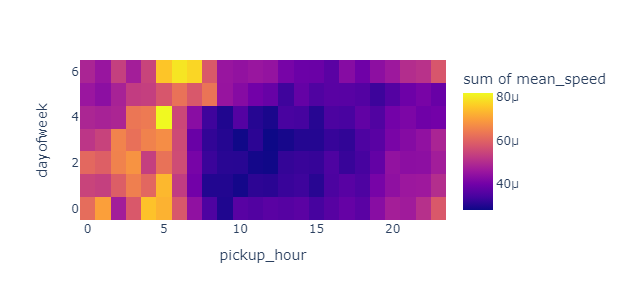

In [73]:
#요일, 시간에 따른 평균속력 시각화 
# dayofweek, pickup_hour, speed_mean
tidydata = df_feature.pivot_table(
    index = 'dayofweek',
    columns = 'pickup_hour',
    values = 'speed',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'mean_speed'}, axis =1)

px.density_heatmap(
    data_frame = tidydata,
    x = 'pickup_hour',
    y = 'dayofweek',
    z = 'mean_speed',
    nbinsx=24,
    nbinsy=7,
    height=300
)


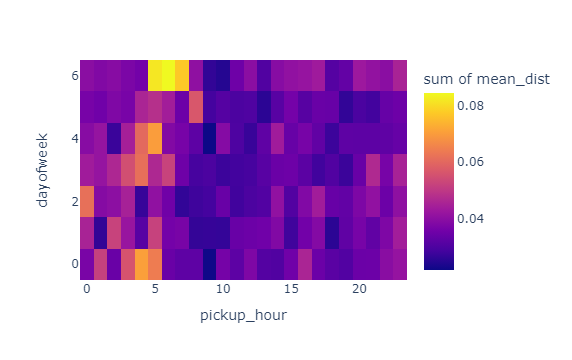

In [22]:
#요일,시간에 따른 평균이동거리 시각화 
tidydata2 = df_feature.pivot_table(
    index = 'dayofweek',
    columns = 'pickup_hour',
    values = 'dist',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'mean_dist'}, axis = 1)

fig2 = px.density_heatmap(
    data_frame = tidydata2,
    x = 'pickup_hour',
    y = 'dayofweek',
    z = 'mean_dist',
    nbinsx=24,
    nbinsy=7,
    height=300
)

In [40]:
# 속력별 경로시각화 
#속력을 quantile에 따라 4구간으로 나누고, 구간별 이동경로 대시보드에 시각화
#color = speed_cut
df_small 
print(pd.qcut(df_small['speed'], 4))
print(pd.qcut(df_small['speed'], 4, labels = ['매우느림','조금느림','조금빠름','매우빠름']))

0      (3.63e-05, 4.78e-05]
1      (4.78e-05, 0.000109]
2        (-0.001, 2.63e-05]
3      (2.63e-05, 3.63e-05]
4      (4.78e-05, 0.000109]
               ...         
141    (4.78e-05, 0.000109]
142    (2.63e-05, 3.63e-05]
143    (4.78e-05, 0.000109]
144      (-0.001, 2.63e-05]
145      (-0.001, 2.63e-05]
Name: speed, Length: 146, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 2.63e-05] < (2.63e-05, 3.63e-05] < (3.63e-05, 4.78e-05] < (4.78e-05, 0.000109]]
0      조금빠름
1      매우빠름
2      매우느림
3      조금느림
4      매우빠름
       ... 
141    매우빠름
142    조금느림
143    매우빠름
144    매우느림
145    매우느림
Name: speed, Length: 146, dtype: category
Categories (4, object): ['매우느림' < '조금느림' < '조금빠름' < '매우빠름']


In [125]:
df_small_feature= df_small.assign(
    log_trip_duration = np.log(df.trip_duration),
    pickup_datetime = df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = df.dropoff_datetime.apply(pd.to_datetime),
    dist = np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small_feature

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,pickup_hour,dropoff_hour,dayofweek
0,id2875421,NaN,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,0.017680,0.000039,17,17,0
1,id3667993,NaN,2016-06-01 11:48:41,2016-06-01 12:19:07,1,-73.980522,40.730530,-73.997993,40.746220,N,486,7.509883,0.033027,0.000068,11,12,2
2,id2002463,NaN,2016-01-02 01:16:42,2016-01-02 01:19:56,1,-73.965652,40.768398,-73.960068,40.779308,N,501,5.267858,0.008282,0.000017,1,1,5
3,id1635353,NaN,2016-03-01 06:40:18,2016-03-01 07:01:37,5,-73.985092,40.759190,-73.962151,40.709850,N,1711,7.153834,0.060363,0.000035,6,7,1
4,id1850636,NaN,2016-06-11 16:59:15,2016-06-11 17:33:27,1,-73.994537,40.750439,-74.025719,40.631100,N,1856,7.626570,0.057778,0.000031,16,17,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,id0621879,NaN,2016-03-04 21:09:07,2016-03-04 21:17:40,1,-73.950783,40.743614,-74.006218,40.722729,N,1200,6.240276,0.022427,0.000019,21,21,4
142,id2587483,NaN,2016-05-27 05:40:10,2016-05-27 05:43:44,2,-73.953903,40.787079,-73.940842,40.792461,N,493,5.365976,0.024101,0.000049,5,5,4
143,id1030598,NaN,2016-05-08 22:49:35,2016-05-08 22:56:42,1,-74.005066,40.719143,-74.006065,40.735134,N,335,6.056784,0.024270,0.000072,22,22,6
144,id3094934,NaN,2016-01-15 15:26:05,2016-01-15 15:33:44,1,-73.986153,40.722431,-73.985977,40.762669,N,1720,6.129050,0.022523,0.000013,15,15,4


In [126]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small_feature.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small_feature.groupby('id')]).reset_index(drop=True)
df_small_feature2 = df_left.merge(df_right)
df_small_feature2

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type
0,id2875421,NaN,1,N,455,6.120297,0.017680,0.000039,0,2016-03-14 17:24:55,-73.982155,40.767937,17,pickup
1,id2875421,NaN,1,N,455,6.120297,0.017680,0.000039,0,2016-03-14 17:32:30,-73.964630,40.765602,17,dropoff
2,id3667993,NaN,1,N,486,7.509883,0.033027,0.000068,2,2016-06-01 11:48:41,-73.980522,40.730530,11,pickup
3,id3667993,NaN,1,N,486,7.509883,0.033027,0.000068,2,2016-06-01 12:19:07,-73.997993,40.746220,12,dropoff
4,id2002463,NaN,1,N,501,5.267858,0.008282,0.000017,5,2016-01-02 01:16:42,-73.965652,40.768398,1,pickup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,id1030598,NaN,1,N,335,6.056784,0.024270,0.000072,6,2016-05-08 22:56:42,-74.006065,40.735134,22,dropoff
288,id3094934,NaN,1,N,1720,6.129050,0.022523,0.000013,4,2016-01-15 15:26:05,-73.986153,40.722431,15,pickup
289,id3094934,NaN,1,N,1720,6.129050,0.022523,0.000013,4,2016-01-15 15:33:44,-73.985977,40.762669,15,dropoff
290,id0503659,NaN,2,N,1020,6.918695,0.050591,0.000050,3,2016-05-12 19:19:45,-73.952209,40.784500,19,pickup


In [127]:
tidydata3 = df_small_feature2.sort_values('speed').assign(평균속력 = lambda df: pd.qcut(df.speed,4,labels=['매우느림','조금느림','조금빠름','매우빠름']))
tidydata3

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type,평균속력
178,id1394748,NaN,3,N,1852,4.477337,0.000630,3.403551e-07,4,2016-06-17 15:29:31,-73.999489,40.734100,15,pickup,매우느림
179,id1394748,NaN,3,N,1852,4.477337,0.000630,3.403551e-07,4,2016-06-17 15:30:59,-73.962807,40.673012,15,dropoff,매우느림
162,id3281834,NaN,1,N,246,6.003887,0.000106,4.319722e-07,1,2016-05-03 22:10:35,-74.007378,40.739368,22,pickup,매우느림
163,id3281834,NaN,1,N,246,6.003887,0.000106,4.319722e-07,1,2016-05-03 22:17:20,-74.006897,40.744133,22,dropoff,매우느림
74,id2673049,NaN,2,N,2192,4.795791,0.002223,1.013945e-06,1,2016-02-02 11:45:35,-73.970016,40.789600,11,pickup,매우느림
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,id2210145,NaN,2,N,296,7.445418,0.121171,4.093608e-04,4,2016-03-18 23:36:22,-73.987381,40.750530,23,pickup,매우빠름
160,id2484944,NaN,1,N,344,7.835975,0.208056,6.048130e-04,4,2016-05-06 14:10:08,-73.944717,40.779381,14,pickup,매우빠름
161,id2484944,NaN,1,N,344,7.835975,0.208056,6.048130e-04,4,2016-05-06 14:52:18,-73.959541,40.766785,14,dropoff,매우빠름
144,id3098811,NaN,2,N,324,7.912423,0.247885,7.650770e-04,0,2016-03-14 07:15:21,-73.994713,40.725658,7,pickup,매우빠름


In [128]:
fig3 = px.line_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = '평균속력',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
)
scatter_data = px.scatter_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = '평균속력',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
).data
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)

for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['name'] += ' (path)'
    else:
        fig3.data[i]['name'] += ' (pickup/dropoff)'
    

#fig3.show(config={'scrollZoom':False})

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



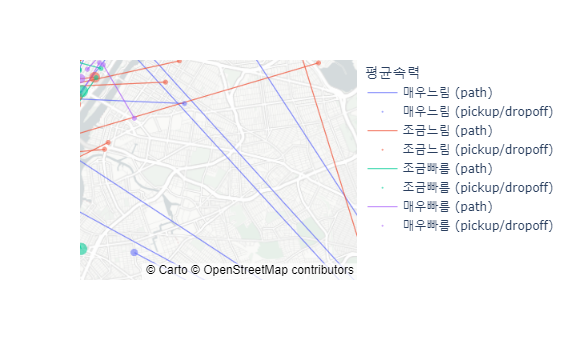

In [129]:
fig3.show()

In [107]:
# for i in range(150):
#     print(fig3.data[i])

fig3.data[i]['legendgroup'] = fig3.data[i]['legendgroup'] + ' (path)'

'매우느림 (path)'

In [108]:
fig3.data[0]

Scattermapbox({
    'hovertemplate': '평균속력=매우느림<br>id=id1891478<br>latitude=%{lat}<br>longitude=%{lon}<extra></extra>',
    'lat': array([40.75983047, 40.75983047]),
    'legendgroup': '매우느림',
    'line': {'color': '#636efa', 'width': 1},
    'lon': array([-73.97090149, -73.97090149]),
    'mode': 'lines',
    'name': '매우느림',
    'opacity': 0.8,
    'showlegend': True,
    'subplot': 'mapbox'
})

In [113]:
for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['legendgroup'] + ' (path)'
    else:
        fig3.data[i]['legendgroup'] + ' (pickup/dropoff)'

In [112]:
len(fig3.data)

150